In [1]:
import gym
import sys
import numpy as np
import random as rn
import cv2
import time
import functools
import datetime
import tensorflow as tf
from agents.DDQN import *
from IPython import display
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

np.set_printoptions(threshold=sys.maxsize)

Using TensorFlow backend.


#### Set seed

In [2]:
SEED = 789325

rn.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

#### Environment

In [3]:
def build_environment(envName="CartPole-v0", seed=None):
    env = gym.make(envName)        
    if seed is not None:
        env.seed(seed)    
    
    return env

#### Show Environment information

In [4]:
env = build_environment(seed=SEED)

# size of each action
action_size = env.action_space.n
print('Actions: ', action_size)
if hasattr(env.env, 'get_action_meanings'):
    print(env.env.get_action_meanings())

# examine the state space 
states = env.observation_space.shape
state_size = states[0]
print('Size of state:', state_size)

env.close()

Actions:  2
Size of state: 4


# Training

In [5]:
def build_agent(pre_trained=None):
    return DDQNAgent(state_size,
                     action_size,
                     buffer_size=2000,
                     epsilon_start=0.5,
                     epsilon_steps_to_min=3500,
                     mode="DuelingDQN",
                     use_PER=True,
                     pre_trained=pre_trained)

In [6]:
logdir = "logs/" + time.strftime("%Y%m%d_%H%M%S")
writer = tf.summary.create_file_writer(logdir)

In [7]:
SAVE_EVERY_EPISODES = 100
LEARNING_START_AFTER_STEPS = 500
EPISODES = 80
SCORE_TO_SOLVE = 195.0

UPDATE_MODE = 'soft'
UPDATE_TARGET_FREQUENCY = 10

In [8]:
def train():
    env = build_environment(seed=SEED)
    agent = build_agent()
    
    max_reward = -9999999    
    game_rewards_deque = deque(maxlen=100)    
    frame_count = 0
    
    print("Training started: " + str(datetime.datetime.now()))
    
    frame_count = 0
    
    for i_episode in range(1, EPISODES+1):
        state = env.reset()
            
        game_reward = 0
        steps = 0
        
        while True:
            frame_count += 1
            steps += 1
            
            state = agent.preprocess(state)                
            action = agent.act(state)            
            
            next_state, reward, done, info = env.step(action)              
            game_reward += reward
        
            agent.remember(state[0], action, reward, next_state, done)
            
            state = next_state
            
            if frame_count % 10000 == 0:
                print("Step count: {}".format(frame_count))
            
            if done:
                break            
            
            if frame_count > LEARNING_START_AFTER_STEPS:                
                agent.train()
                if UPDATE_MODE == "soft":
                    agent.soft_update_target_network()
                
            
            if UPDATE_MODE == "hard" and frame_count % UPDATE_TARGET_FREQUENCY == 0:
                agent.hard_update_target_network()
    
        # Log episode reward
        with writer.as_default():
            tf.summary.scalar("epsilon", agent.epsilon, step=i_episode)
            tf.summary.scalar("game_reward", game_reward, step=i_episode)        
            
        if i_episode % SAVE_EVERY_EPISODES == 0:
            print("Save after {} episodes.".format(i_episode))
            agent.save()             
        
        game_rewards_deque.append(game_reward)
        
        if game_reward > max_reward:
            print("Episode {}: Step {} reward {}: ".format(i_episode, frame_count, game_reward))
            max_reward = game_reward
            agent.save()        
        
        if np.mean(game_rewards_deque) >= SCORE_TO_SOLVE:
            agent.save()
            print("Solved in Episode {} Step {} reward {}: ".format(i_episode, frame_count, game_reward))
            break      
    
    env.close()
    agent.save()
   
train()
print("Training finished")

Training started: 2019-12-29 13:29:18.235840
Episode 1: Step 15 reward 15.0: 
Save model...
Episode 5: Step 80 reward 30.0: 
Save model...
Episode 6: Step 123 reward 43.0: 
Save model...
Episode 7: Step 180 reward 57.0: 
Save model...


D:\Deep Learning\Reinforcement-Learning\OpenAI\CartPole-v0\memory.py:47: RuntimeWarning: divide by zero encountered in double_scalars
  max_weight = (p_min * n) ** (-self.PER_b)
D:\Deep Learning\Reinforcement-Learning\OpenAI\CartPole-v0\memory.py:47: RuntimeWarning: divide by zero encountered in double_scalars
  max_weight = (p_min * n) ** (-self.PER_b)


Episode 46: Step 860 reward 58.0: 
Save model...
Episode 47: Step 947 reward 87.0: 
Save model...
Episode 61: Step 1757 reward 92.0: 
Save model...
Episode 65: Step 2039 reward 105.0: 
Save model...
Episode 67: Step 2269 reward 133.0: 
Save model...
Episode 68: Step 2469 reward 200.0: 
Save model...
Save model...
Training finished


# Show Result

Episode finished with score: 161.0


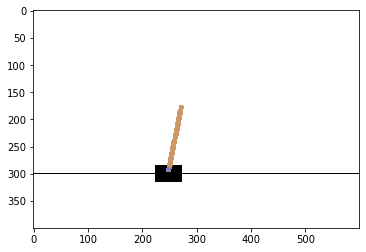

In [9]:
env = build_environment(seed=SEED)
agent = build_agent(pre_trained='model.h5')

state = env.reset()
final_reward = 0

img = plt.imshow(env.render(mode='rgb_array'))
while True:
    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)

    state = np.reshape(state, [1, state_size])
    action = agent.act(state)    
    next_state, reward, done, info = env.step(action)
    final_reward += reward 
    
    state = next_state
    
    if done:
        print("Episode finished with score: {}".format(final_reward))
        break
env.close()        